# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
d.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


## Task 1. Prior predictive checks

In [4]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /root/ISZ_DA/Lab_04/height_1_ppc.stan to exe file /root/ISZ_DA/Lab_04/height_1_ppc
INFO:cmdstanpy:compiled model executable: /root/ISZ_DA/Lab_04/height_1_ppc
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

In [5]:
prior_height = sim.draws_pd()
prior_height.head()

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,218.623,8.12614,204.427
1,0.0,0.0,185.980,70.33170,295.105
2,0.0,0.0,172.566,11.77890,180.293
3,0.0,0.0,181.451,19.51800,216.821
4,0.0,0.0,158.795,4.67849,166.163


Text(0, 0.5, 'Amount')

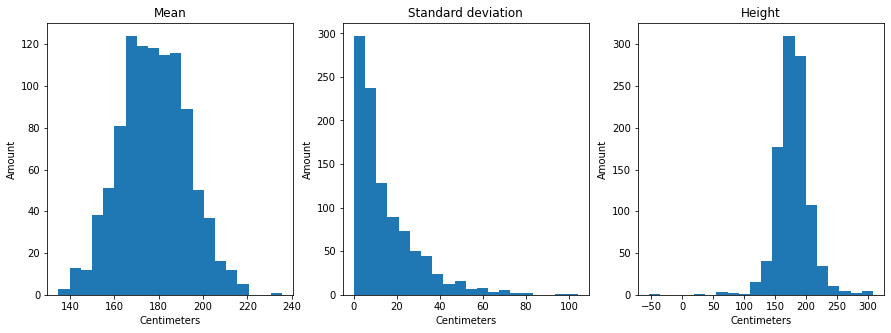

In [6]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(prior_height["mu"],bins=20, label='Mean')
axes[0].set_title("Mean")
axes[0].set_xlabel("Cm")
axes[0].set_ylabel("Count")

axes[1].hist(prior_height["sigma"],bins=20,label='Std')
axes[1].set_title("Standard deviation")
axes[1].set_xlabel("Cm")
axes[1].set_ylabel("Count")

axes[2].hist(prior_height["height"],bins=20, label='Height')
axes[2].set_title("Height")
axes[2].set_xlabel("Cm")
axes[2].set_ylabel("Count")

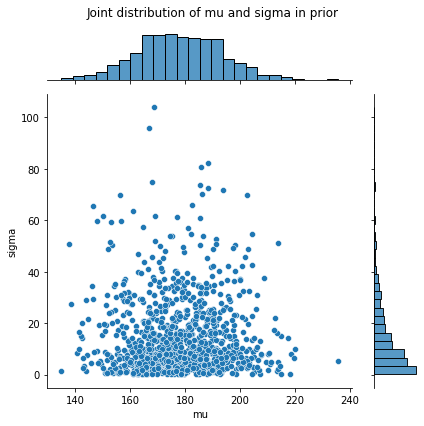

In [7]:
sb.jointplot(prior_height[["mu","sigma"]],x=prior_height["mu"],y=prior_height["sigma"])
plt.suptitle("Joint distribution of mu and sigma in prior")
plt.tight_layout()

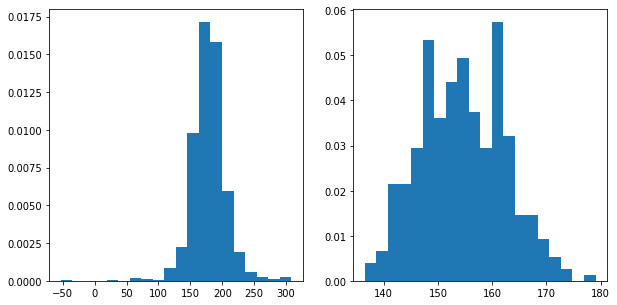

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(prior_height["height"],bins=20,density=True)
axes[0].set_title("Priors")
axes[1].hist(d["height"],bins=20,density=True)
axes[1].set_title("Samples")
plt.show()

In [ ]:
# This data would be possible using priors, mean wiybd beed to be set for 155, and std at around 15

## Task 2. Model fit and evaluation

In [9]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /root/ISZ_DA/Lab_04/height_1_fit.stan to exe file /root/ISZ_DA/Lab_04/height_1_fit
INFO:cmdstanpy:compiled model executable: /root/ISZ_DA/Lab_04/height_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/ISZ_DA/Lab_04/height_1_fit.hpp /root/ISZ_DA/Lab_04/height_1_fit.stan
Warning in '/root/ISZ_DA/Lab_04/height_1_fit.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math

In [10]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


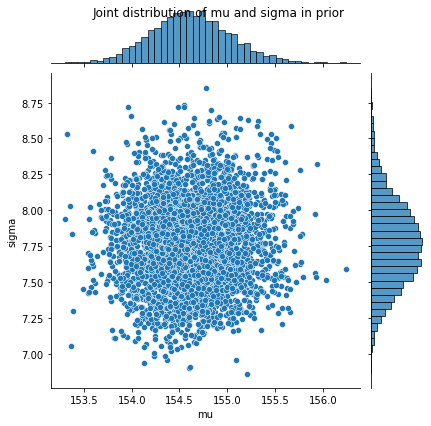

In [14]:
df_fit = fit.draws_pd()
df_fit.head()
sb.jointplot(df_fit[["mu", 'sigma']], x=df_fit["mu"], y=df_fit["sigma"])
plt.suptitle("Joint distribution of mu and sigma in prior")
plt.show()

Text(0, 0.5, 'Normalized count')

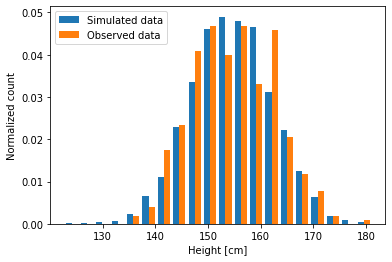

In [17]:
plt.hist([df_fit["height"], d["height"]], density=True, bins=20, label=["Simulated data","Observed data"] )
plt.legend()
plt.xlabel("Height [cm]")
plt.ylabel("Normalized count")

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [18]:
d["c_weight"] = d["weight"].mean() - d["weight"]
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


## Task 4. Prior predictive checks
 

In [19]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /root/ISZ_DA/Lab_04/height_2a_ppc.stan to exe file /root/ISZ_DA/Lab_04/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /root/ISZ_DA/Lab_04/height_2a_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/ISZ_DA/Lab_04/height_2a_ppc.hpp /root/ISZ_DA/Lab_04/height_2a_ppc.stan
Warning in '/root/ISZ_DA/Lab_04/height_2a_ppc.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/ISZ_DA/Lab_04/height_2a_ppc.stan', line 10, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code

chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

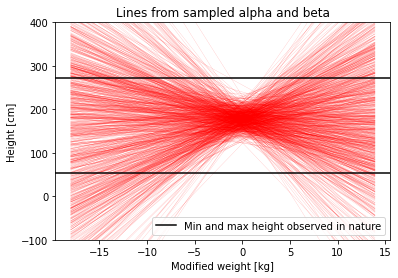

In [23]:
df_sim = sim.draws_pd()
df_sim.describe()

min_weight = d.c_weight.min()
max_weight= d.c_weight.max()
min_val = df_sim["alpha"]+df_sim["beta"]*min_weight
max_val = df_sim["alpha"]+df_sim["beta"]*max_weight
plt.plot([min_weight,max_weight],[min_val, max_val], linewidth=0.2, color='r', alpha=0.4)
plt.axhline(y=272, color='k', label="Min and max height observed in nature")
plt.axhline(y=54.6, color='k')
plt.ylim(-100,400)
plt.title("Lines from sampled alpha and beta")
plt.xlabel("Modified weight [kg]")
plt.ylabel("Height [cm]")
plt.legend()
plt.show()

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [24]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /root/ISZ_DA/Lab_04/height_2b_ppc.stan to exe file /root/ISZ_DA/Lab_04/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /root/ISZ_DA/Lab_04/height_2b_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/ISZ_DA/Lab_04/height_2b_ppc.hpp /root/ISZ_DA/Lab_04/height_2b_ppc.stan
Warning in '/root/ISZ_DA/Lab_04/height_2b_ppc.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/ISZ_DA/Lab_04/height_2b_ppc.stan', line 10, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code

In [25]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


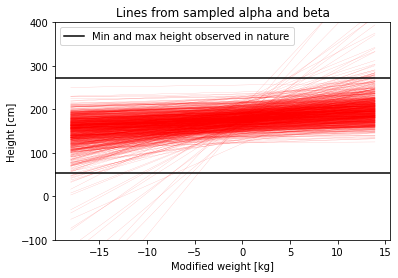

In [26]:
df_sim = sim.draws_pd()
df_sim.describe()

min_weight = d.c_weight.min()
max_weight= d.c_weight.max()
min_val = df_sim["alpha"]+df_sim["beta"]*min_weight
max_val = df_sim["alpha"]+df_sim["beta"]*max_weight
plt.plot([min_weight,max_weight],[min_val, max_val], linewidth=0.2, color='r', alpha=0.4)
plt.axhline(y=272, color='k', label="Min and max height observed in nature")
plt.axhline(y=54.6, color='k')
plt.ylim(-100,400)
plt.title("Lines from sampled alpha and beta")
plt.xlabel("Modified weight [kg]")
plt.ylabel("Height [cm]")
plt.legend()
plt.show()

1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

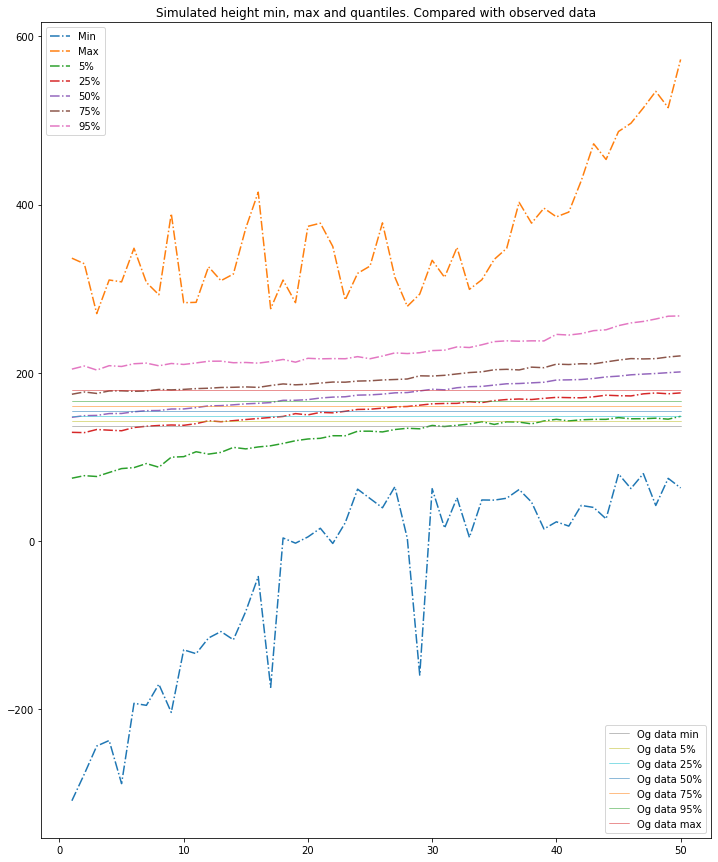

In [29]:
sim_stats = df_sim.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
sim_05 = sim_stats.loc[['5%']].iloc[:,5:]
sim_25 = sim_stats.loc[['25%']].iloc[:,5:]
sim_50 = sim_stats.loc[['mean']].iloc[:,5:]
sim_75 = sim_stats.loc[['75%']].iloc[:,5:]
sim_95 = sim_stats.loc[['95%']].iloc[:,5:]
sim_max = sim_stats.loc[['max']].iloc[:,5:]
sim_min = sim_stats.loc[['min']].iloc[:,5:]

x = np.linspace(1,50)

plt.figure(figsize=(12,15))
line1, = plt.plot(x, sim_min.values.T, '-.', label="Min")
line2, = plt.plot(x, sim_max.values.T, '-.', label="Max")
line3, = plt.plot(x, sim_05.values.T, '-.', label="5%")
line4, = plt.plot(x, sim_25.values.T, '-.', label="25%")
line5, = plt.plot(x, sim_50.values.T, '-.', label="50%")
line6, = plt.plot(x, sim_75.values.T, '-.', label="75%")
line7, = plt.plot(x, sim_95.values.T, '-.', label="95%")
plt.title("Simulated height min, max and quantiles. Compared with observed data")
legend1 = plt.legend(handles=[line1,line2,line3,line4,line5,line6,line7],loc='upper left')
plt.gca().add_artist(legend1)

#plotting lines for data
data_stats = d.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])["height"].drop(["count","std","mean"])
lines2 = []
for name,stat in data_stats.items():
    line, = plt.plot([1,50],[stat,stat], linewidth=0.5, label="Og data "+name)
    lines2.append(line)
plt.legend(handles=lines2, loc='lower right')
plt.show()

## Task 6. Fitting and evaluating model


In [30]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /root/ISZ_DA/Lab_04/height_2_fit.stan to exe file /root/ISZ_DA/Lab_04/height_2_fit
INFO:cmdstanpy:compiled model executable: /root/ISZ_DA/Lab_04/height_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/ISZ_DA/Lab_04/height_2_fit.hpp /root/ISZ_DA/Lab_04/height_2_fit.stan
Warning in '/root/ISZ_DA/Lab_04/height_2_fit.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/ISZ_DA/Lab_04/height_2_fit.stan', line 25, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g+

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [31]:
N = 50
data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


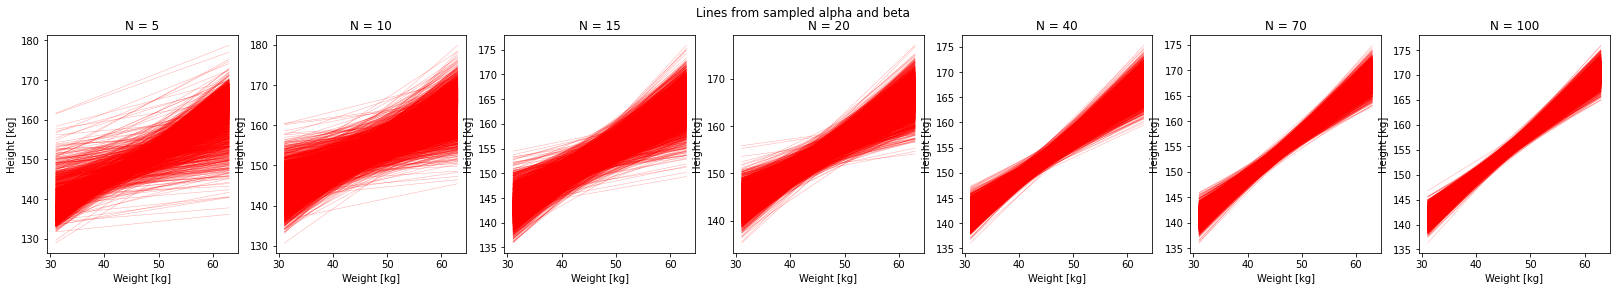

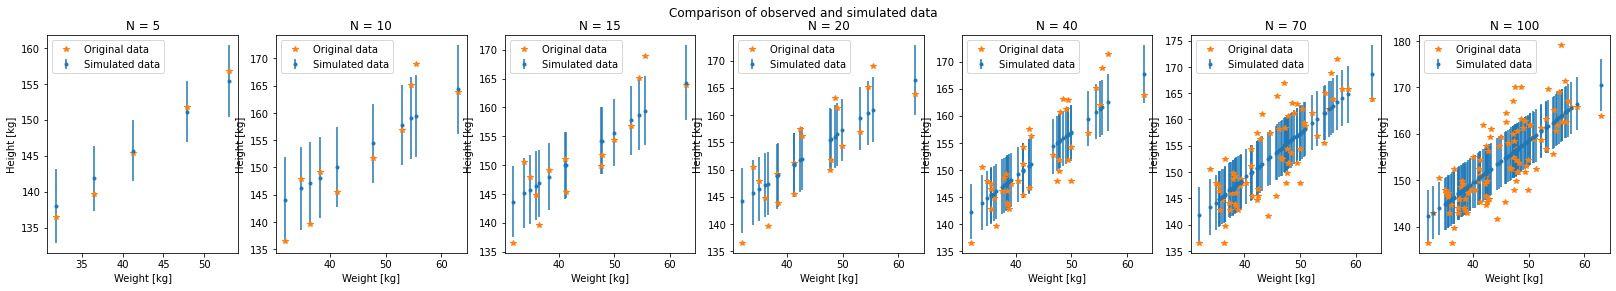

In [35]:
list_of_Ns = [5,10,15,20,40,70,100]
min_weight, max_weight = d.weight.min(),d.weight.max()

fig, axes = plt.subplots(1,7, figsize=(7*4,4))
fig2, axes2 = plt.subplots(1,7, figsize=(7*4,4))
for (idx, N) in enumerate(list_of_Ns):
    data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df_fit = fit.draws_pd()
    alpha = df_fit["alpha"]
    beta = df_fit["beta"]
    fig
    fig.suptitle("Lines from sampled alpha and beta")
    axes[idx].plot([min_weight,max_weight],[alpha+beta*min_weight, alpha+beta*max_weight],linewidth=0.5,alpha=0.33,color='r')
    #axes[idx].set_ylim(50,280)
    axes[idx].set_title(f"N = {N}")
    axes[idx].set_xlabel("Weight [kg]")
    axes[idx].set_ylabel("Height [kg]")

    fig2
    fig2.suptitle("Comparison of observed and simulated data")
    df_fit = df_fit.describe()
    axes2[idx].errorbar(d.weight.iloc[:N].values,df_fit.loc[["mean"]].iloc[:,-N:].to_numpy()[0], yerr=df_fit.loc[["std"]].iloc[:,-N:].to_numpy()[0], fmt='.', label="Simulated data")
    axes2[idx].plot(d.weight.iloc[:N].values,d.height.iloc[:N].values, '*', label="Original data")
    axes2[idx].set_title(f"N = {N}")
    axes2[idx].set_xlabel("Weight [kg]")
    axes2[idx].set_ylabel("Height [kg]")
    axes2[idx].legend()
plt.show()

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

In [ ]:
#Ad1. For this model  alpha in this case tells us what height our model expects when weight of individual is equal to mean weight
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')
N = 50
data_fit = {'N': N, 'weight': d.c_weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

df_fit = fit.draws_pd()
min_weight,max_weight = d.c_weight.min(),d.c_weight.max()

plt.plot([min_weight,max_weight],[df_fit["alpha"]+df_fit["beta"]*min_weight, df_fit["alpha"]+df_fit["beta"]*max_weight],linewidth=0.5)
plt.title("Testing model on centered weight")
plt.xlabel("Modified weight [kg]")
plt.ylabel("Height [cm]")